<a href="https://colab.research.google.com/github/slifer4195/csce-636/blob/main/Moodme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading dataset from kaggle

In [1]:
! pip install kaggle

In [2]:
! pip install pillow
from PIL import Image

In [4]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [6]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [11]:
! kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [8]:
! unzip face_data.zip

unzip:  cannot find or open face_data.zip, face_data.zip.zip or face_data.zip.ZIP.


Import libraries

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation, MaxPooling2D
from keras.models import Model, Sequential

from tensorflow.keras.optimizers import Adam,SGD , RMSprop # - Works

Displaying datasets

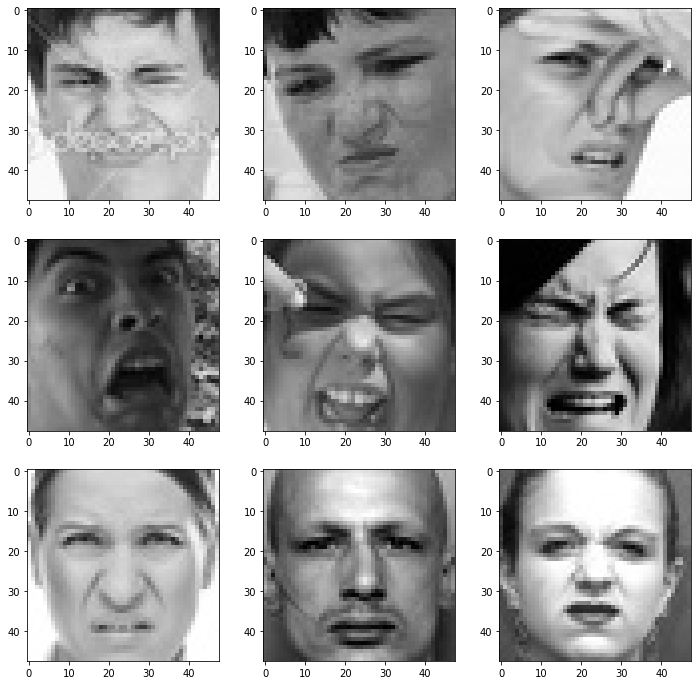

In [13]:
picture_size = 48
folder_path = "/content/images/"

expression = 'disgust/'
plt.figure(figsize = (12,12))
for i in range(1,10,1):
  plt.subplot(3,3,i)
  img = load_img(folder_path + "train/" + expression + os.listdir(folder_path + "train/" + expression)[i], target_size = (picture_size,picture_size))
  plt.imshow(img)
plt.show()

Setting training and test datasets

In [14]:
batch_size = 128
datagen_train = ImageDataGenerator()
datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(folder_path + "train", target_size = (picture_size,picture_size), color_mode = "grayscale"
                                              ,batch_size = batch_size ,class_mode = "categorical", shuffle = True)

test_set = datagen_train.flow_from_directory(folder_path + "validation", target_size = (picture_size,picture_size), color_mode = "grayscale"
                                              ,batch_size = batch_size ,class_mode = "categorical", shuffle = True)


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


neural network

In [19]:


no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))



opt = Adam(lr = 0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_14 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 128)      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [21]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 48

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])
history = model.fit_generator(generator=train_set,
                                steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=epochs,
                                validation_data = test_set,
                                validation_steps = test_set.n//test_set.batch_size,
                                callbacks=callbacks_list
                                )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/48
225/225 [==============================] - 40s 127ms/step - loss: 1.7824 - accuracy: 0.3133 - val_loss: 1.6185 - val_accuracy: 0.4081 - lr: 0.0010
Epoch 2/48
225/225 [==============================] - 28s 123ms/step - loss: 1.4413 - accuracy: 0.4459 - val_loss: 1.4641 - val_accuracy: 0.4700 - lr: 0.0010
Epoch 3/48
225/225 [==============================] - 28s 123ms/step - loss: 1.2872 - accuracy: 0.5067 - val_loss: 1.2377 - val_accuracy: 0.5226 - lr: 0.0010
Epoch 4/48
225/225 [==============================] - 28s 123ms/step - loss: 1.1997 - accuracy: 0.5418 - val_loss: 1.2266 - val_accuracy: 0.5311 - lr: 0.0010
Epoch 5/48
225/225 [==============================] - 28s 123ms/step - loss: 1.1316 - accuracy: 0.5731 - val_loss: 1.4443 - val_accuracy: 0.4328 - lr: 0.0010
Epoch 6/48
225/225 [==============================] - 28s 123ms/step - loss: 1.0758 - accuracy: 0.5915 - val_loss: 1.1322 - val_accuracy: 0.5702 - lr: 0.0010
Epoch 7/48
225/225 [==============================] 